In [1]:
# this command is executed twice for interactive plotting in Jupyter notebook
%matplotlib notebook
%matplotlib notebook

In [18]:
NEW_EXPERIMENTS = True
NEW_AVERAGING = True
NEW_METRICS = True

In [25]:
# standard modules
from pathlib import Path, PosixPath
import pickle as pkl
import pandas as pd
from tqdm.notebook import tqdm
import xarray
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# custom imports
from model.camels_utilities import load_usgs, load_forcings
from codebase.evaluation.metrics import get_available_metrics, calculate_all_metrics

In [5]:
# test dates
test_start_date = '10/01/1989'
test_end_date = '09/30/1999'
test_dates = pd.date_range(test_start_date,test_end_date)

# train dates
train_start_date = '01/10/1999'
train_end_date = '09/30/2008'
train_dates = pd.date_range(train_start_date, train_end_date)

In [61]:
# experiment metadata
results_dir = Path('/home/gsnearing/projects/multi-inputs/SACSMA-SNOW17/results')
forcing_types = ['daymet', 'maurer','nldas']
config_nums = [1]#list(range(1,11))

In [62]:
# get list of basins from actual results (not a basin file)
dummy_run_dir = results_dir / 'daymet/config_1'
basin_files = list(Path(dummy_run_dir).glob('*.pkl'))
basins = []
for bfile in basin_files:
    basins.append(str(bfile).split('/')[-1].split('.')[0])
num_basins = len(basins)

In [59]:
# load discharge data
if NEW_EXPERIMENTS:
    
    camels_dir = Path('/home/gsnearing/projects/camels_data/basin_dataset_public_v1p2')
    usgs = pd.DataFrame(columns=basins)
    for basin in tqdm(basins):
        _, area = load_forcings(basin,'nldas')
        df = load_usgs(basin, area)
        usgs[basin] = df['QObs']

    with open('notebook_env_saves/usgs_runoff_data.pkl', 'wb') as f:
        pkl.dump(usgs, f)

else:
    with open('notebook_env_saves/usgs_runoff_data.pkl', 'rb') as f:
        usgs = pkl.load(f)     

In [60]:
# load calibrated sacsma runs
if NEW_EXPERIMENTS:

    # init storage
    print('Initializing dataframe for storing all sacsma runs')
    all_sacsma_restarts = {}
    experiment_multiindex = pd.MultiIndex.from_product([forcing_types, config_nums])
    for basin in tqdm(basins):
        all_sacsma_restarts[basin] = pd.DataFrame(columns=experiment_multiindex)
    
    print('Loading all sacsma runs')
    for ftype in forcing_types:
        print(ftype)
        for cnum in tqdm(config_nums):
            run_dir = results_dir / ftype / f'config_{cnum}'
            basin_files = list(run_dir.glob('*.pkl')) 
            assert len(basin_files) == num_basins
            for basin in basins:
                basin_file = run_dir / f'{basin}.pkl'
                with open (basin_file, 'rb') as f:
                    data = pkl.load(f)
                all_sacsma_restarts[basin][(ftype,cnum)] = data[1]
                
    print('Calcualting ensemble means')
    sacsma = {}
    for basin in tqdm(basins):
        sacsma[basin] = pd.DataFrame(index=all_sacsma_restarts[basin][(ftype,cnum)].index, columns=forcing_types)
        for ftype in forcing_types:
            sacsma[basin][ftype] = all_sacsma_restarts[basin][ftype].mean(axis=1)
        
    print('Saving ensemble means')
    with open('notebook_env_saves/sacsma_mean_hydrographs.pkl', 'wb') as f:
        pkl.dump(sacsma, f)

else:
    with open('notebook_env_saves/sacsma_mean_hydrographs.pkl', 'rb') as f:
        sacsma = pkl.load(f)     

Initializing dataframe for storing all sacsma runs



Loading all sacsma runs
daymet



maurer


AssertionError: 

<IPython.core.display.Javascript object>


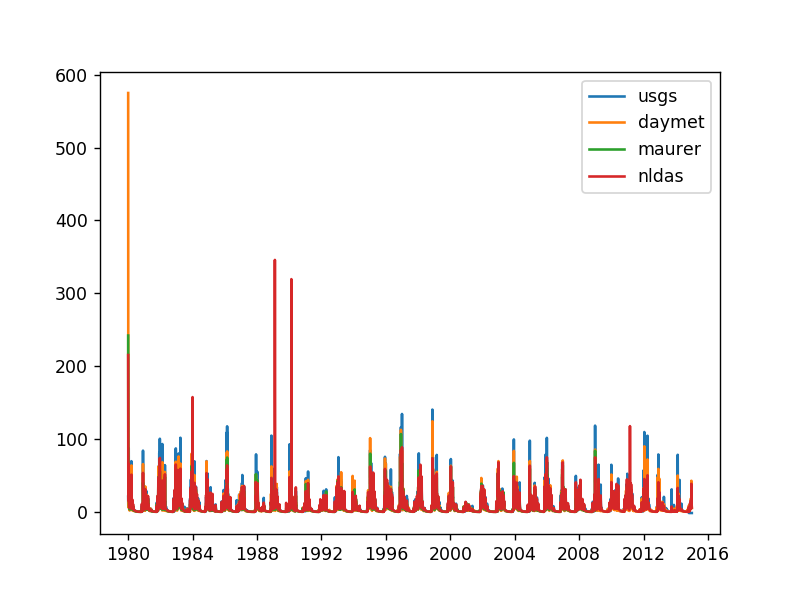

In [12]:
plt.plot(usgs[basin], label='usgs')
for ftype in forcing_types:
    plt.plot(sacsma[basin][ftype], label=ftype)
plt.legend()

In [86]:
def model_averaging(ensemble_df, observation_df, train_dates):
    
    # extract models that we will average over
    models = list(ensemble_df.columns)
    
    # estimate weights based on training-period fits
    diff = ensemble_df.loc[train_dates].sub(observation_df.loc[train_dates], axis=0)
    weights = np.sqrt((diff**2).mean())
    
    
    weights['nldas'] = 1
    weights['daymet'] = 1
    weights['maurer'] = 1
    
    weights = weights / np.sum(weights)

    
    # weight test period into a single hydrograph
    hydrograph = ensemble_df.dot(weights)
        
    return hydrograph

In [87]:
# run mixing strategy
if NEW_AVERAGING:

    sacsma_mixture_hydrograph = pd.DataFrame(columns=basins)
    for basin in tqdm(basins):
        sacsma_mixture_hydrograph[basin] = model_averaging(sacsma[basin], 
                                                           usgs[basin], 
                                                           train_dates)
    print('Saving model averages means')
    with open('notebook_env_saves/sacsma_model_averages.pkl', 'wb') as f:
        pkl.dump(sacsma_mixture_hydrograph, f)

else:
    with open('notebook_env_saves/sacsma_model_averages.pkl', 'rb') as f:
        sacsma_mixture_hydrograph = pkl.load(f)         


Saving model averages means


In [88]:
# store ensemble means as xarray data sets
if NEW_METRICS:
    
    xr_dict = {}
    for basin in basins:
        xr_data = {}
        xr_data['qsim'] = (('date'), sacsma_mixture_hydrograph.loc[test_dates, basin])
        xr_data['qobs'] = (('date'), usgs.loc[test_dates, basin])
        xr_dict[basin] = xarray.Dataset(data_vars=xr_data,
                                            coords={
                                              'date': test_dates,
                                              'time_step': np.arange(0, 1)
                                            })

    with open('notebook_env_saves/xarray_averaged_sacsma.pkl', 'wb') as f:
        pkl.dump(xr_dict, f)

else:
    with open('notebook_env_saves/xarray_averaged_sacsma.pkl', 'rb') as f:
        xr_dict = pkl.load(f)    

In [89]:
# calculate metrics
if NEW_METRICS:
    
    metric_names = get_available_metrics()
    metrics = pd.DataFrame(index=basins, columns=metric_names)

    # calculating metrics
    for basin in tqdm(basins):
        sim = xr_dict[basin]['qsim']
        obs = xr_dict[basin]['qobs']
        sim_metrics = calculate_all_metrics(obs, sim)

        for metric in metric_names:
            metrics.loc[basin, metric] = sim_metrics[metric]   
    
    with open('notebook_env_saves/metrics.pkl', 'wb') as f:
        pkl.dump(metrics, f)
else:
    with open('notebook_env_saves/metrics.pkl', 'rb') as f:
        metrics = pkl.load(f)    

/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [90]:
metrics.median()

NSE             0.697565
MSE             1.846122
RMSE            1.358721
KGE             0.644980
Alpha-NSE       0.748227
Pearson r       0.854909
Beta-NSE        0.022344
FHV           -24.027673
FMS           -28.650866
FLV            46.511255
Peak-Timing     0.592593
dtype: float64

In [91]:
metrics.mean()

NSE            6.323072e-01
MSE            3.617287e+00
RMSE           1.595603e+00
KGE            6.134942e-01
Alpha-NSE      7.436314e-01
Pearson r      8.288337e-01
Beta-NSE       2.282677e-02
FHV           -2.314566e+01
FMS            5.714959e+05
FLV           -1.687581e+09
Peak-Timing    8.556968e-01
dtype: float64

In [65]:
# store ensemble means as xarray data sets
if NEW_METRICS:
    
    xr_dict_individuals = {}
    for ftype in forcing_types:
        for basin in basins:
            xr_data = {}
            xr_data['qsim'] = (('date'), sacsma[basin].loc[test_dates, ftype])
            xr_data['qobs'] = (('date'), usgs.loc[test_dates, basin])
            xr_dict_individuals[(ftype,basin)] = xarray.Dataset(data_vars=xr_data,
                                                                coords={
                                                                  'date': test_dates,
                                                                  'time_step': np.arange(0, 1)
                                                                })

    with open('notebook_env_saves/xarray_individual_sacsma.pkl', 'wb') as f:
        pkl.dump(xr_dict_individuals, f)

else:
    with open('notebook_env_saves/xarray_individual_sacsma.pkl', 'rb') as f:
        xr_dict_individuals = pkl.load(f)    

In [77]:
# calculate metrics
if NEW_METRICS:
    
    metric_names = get_available_metrics()
    multiindex = pd.MultiIndex.from_product([forcing_types, metric_names])
    metrics_individuals = pd.DataFrame(index=basins, columns=multiindex)

    # calculating metrics
    for ftype in forcing_types:
        print(ftype)
        for basin in tqdm(basins):
            sim = xr_dict_individuals[(ftype,basin)]['qsim']
            obs = xr_dict_individuals[(ftype,basin)]['qobs']
            sim_metrics = calculate_all_metrics(obs, sim)

            for metric in metric_names:
                metrics_individuals.loc[basin, (ftype,metric)] = sim_metrics[metric]   
    
    with open('notebook_env_saves/metrics_individuals.pkl', 'wb') as f:
        pkl.dump(metrics, f)
else:
    with open('notebook_env_saves/metrics_individuals.pkl', 'rb') as f:
        metrics_individuals = pkl.load(f)    

daymet


/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/hom


maurer


/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



nldas


/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [79]:
metrics_individuals.median()

daymet  NSE             0.622060
        MSE             2.349870
        RMSE            1.532929
        KGE             0.607498
        Alpha-NSE       0.781795
        Pearson r       0.817188
        Beta-NSE        0.067523
        FHV           -19.579988
        FMS           -37.978408
        FLV            50.646391
        Peak-Timing     0.678571
maurer  NSE             0.620307
        MSE             2.406768
        RMSE            1.551376
        KGE             0.641193
        Alpha-NSE       0.779466
        Pearson r       0.802749
        Beta-NSE        0.009040
        FHV           -20.461520
        FMS           -23.922080
        FLV            39.437536
        Peak-Timing     0.821429
nldas   NSE             0.623094
        MSE             2.371386
        RMSE            1.539930
        KGE             0.652306
        Alpha-NSE       0.796585
        Pearson r       0.808672
        Beta-NSE        0.000148
        FHV           -19.692161
        FM

In [80]:
metrics_individuals.mean()

daymet  NSE            5.300959e-01
        MSE            4.312896e+00
        RMSE           1.757614e+00
        KGE            5.678097e-01
        Alpha-NSE      7.711897e-01
        Pearson r      7.921349e-01
        Beta-NSE       5.725387e-02
        FHV           -2.024292e+01
        FMS           -3.123038e+01
        FLV           -3.196068e+09
        Peak-Timing    1.000365e+00
maurer  NSE            4.928739e-01
        MSE            4.901943e+00
        RMSE           1.801316e+00
        KGE            5.969384e-01
        Alpha-NSE      7.931155e-01
        Pearson r      7.786475e-01
        Beta-NSE       1.197022e-02
        FHV           -1.883332e+01
        FMS            5.084692e+05
        FLV           -4.406443e+09
        Peak-Timing    1.064561e+00
nldas   NSE            4.525126e-01
        MSE            5.240372e+00
        RMSE           1.833537e+00
        KGE            5.823326e-01
        Alpha-NSE      8.162480e-01
        Pearson r      7.748

In [92]:
400*36

14400

In [101]:
(10732.47) / 400

26.831174999999998